In [126]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import arff
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [127]:
# Logger
def log(title: str):
    print(f"\n{'=' * 20} {title} {'=' * 20}")
    

In [128]:
def plot_all_in_grid(history, cm, y_test, y_probs):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # ========== 1. Training & Validation Loss ==========
    ax = axes[0, 0]
    ax.plot(history.history["loss"], label="Train Loss")
    ax.plot(history.history["val_loss"], label="Val Loss")
    ax.set_title("Model Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

    # ========== 2. Training & Validation Accuracy ==========
    ax = axes[0, 1]
    ax.plot(history.history["accuracy"], label="Train Accuracy")
    ax.plot(history.history["val_accuracy"], label="Val Accuracy")
    ax.set_title("Model Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)

    # ========== 3. Confusion Matrix ==========
    ax = axes[1, 0]
    im = ax.imshow(cm)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")

    plt.colorbar(im, ax=ax)

    # ========== 4. Probability Distribution ==========
    ax = axes[1, 1]
    ax.hist(y_probs[y_test == 0], bins=30, alpha=0.5, label="Class 0")
    ax.hist(y_probs[y_test == 1], bins=30, alpha=0.5, label="Class 1")
    ax.set_title("Predicted Probability Distribution")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


In [129]:
# Data Loading
log("Loading Dataset")
data, _ = arff.loadarff("datasets/credits.arff")
df = pd.DataFrame(data)

for col in df.select_dtypes(include="object"):
        df[col] = df[col].str.decode("utf-8")

print(f"Shape: {df.shape}")
print(f"Head: {df.head()}")
print(f"Class distribution:\n{df['class'].value_counts()}")



==================== Loading Dataset ====================
Shape: (1000, 21)
Head:   checking_status  duration                  credit_history  \
0              <0       6.0  critical/other existing credit   
1        0<=X<200      48.0                   existing paid   
2     no checking      12.0  critical/other existing credit   
3              <0      42.0                   existing paid   
4              <0      24.0              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv         1169.0  no known savings        >=7   
1             radio/tv         5951.0              <100     1<=X<4   
2            education         2096.0              <100     4<=X<7   
3  furniture/equipment         7882.0              <100     4<=X<7   
4              new car         4870.0              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                     4.0         male single    

In [139]:
X = df.drop(columns=["class"])
y = df["class"]

categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(exclude="object").columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols) if numerical_cols else ("num", "passthrough", []),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols) if categorical_cols else ("cat", "passthrough", [])
    ]
)

X_transformed = preprocessor.fit_transform(X)
print("Shape after preprocessing:", X_transformed.shape)


y_encoded = LabelEncoder().fit_transform(y)

joblib.dump(preprocessor, "./models/preprocessor.joblib")

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

class_weights_values = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_values))

Shape after preprocessing: (1000, 61)


In [131]:
# Building
model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(X_train[0].shape),
            tf.keras.layers.Dense(
                128,
                activation=tf.keras.layers.LeakyReLU(negative_slope=0.01),
            ),
            tf.keras.layers.Dropout(0.3),
            
              tf.keras.layers.Dense(
                128,
                activation=tf.keras.layers.LeakyReLU(negative_slope=0.01),
            ),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(
                128,
                activation=tf.keras.layers.LeakyReLU(negative_slope=0.01),
            ),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, 
                activation=tf.nn.sigmoid),
        ]
    )


model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,089 (160.50 KB)

 Trainable params: 41,089 (160.50 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
# Training
log("Training")
history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        class_weight=class_weights,
        verbose=1,
    )



==================== Training ====================
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4828 - loss: 0.7185 - precision: 0.6667 - recall: 0.5419 - val_accuracy: 0.5562 - val_loss: 0.6847 - val_precision: 0.6496 - val_recall: 0.7170
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5406 - loss: 0.6948 - precision: 0.7116 - recall: 0.5925 - val_accuracy: 0.6313 - val_loss: 0.6791 - val_precision: 0.6975 - val_recall: 0.7830
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5375 - loss: 0.6969 - precision: 0.6995 - recall: 0.6101 - val_accuracy: 0.6187 - val_loss: 0.6748 - val_precision: 0.7143 - val_recall: 0.7075
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5859 - loss: 0.6765 - precision: 0.7547 - recall: 0.6167 - val_accuracy: 0.6375 - val_loss: 0.6693 - val_precision: 0.7308 - val_recall: 0.7170
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5844 - loss: 0.6724 - precision: 0.7597 - recall: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.73      0.59        60
           1       0.86      0.68      0.76       140

    accuracy                           0.69       200
   macro avg       0.68      0.71      0.67       200
weighted avg       0.75      0.69      0.71       200



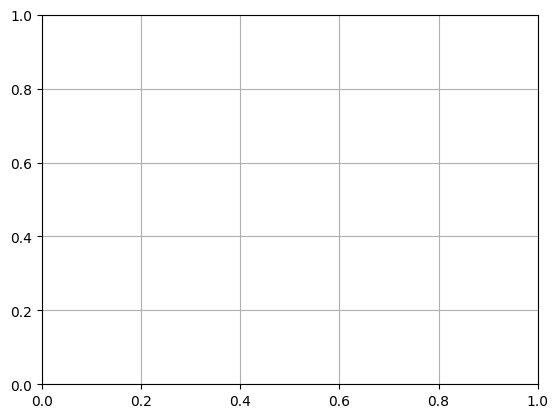

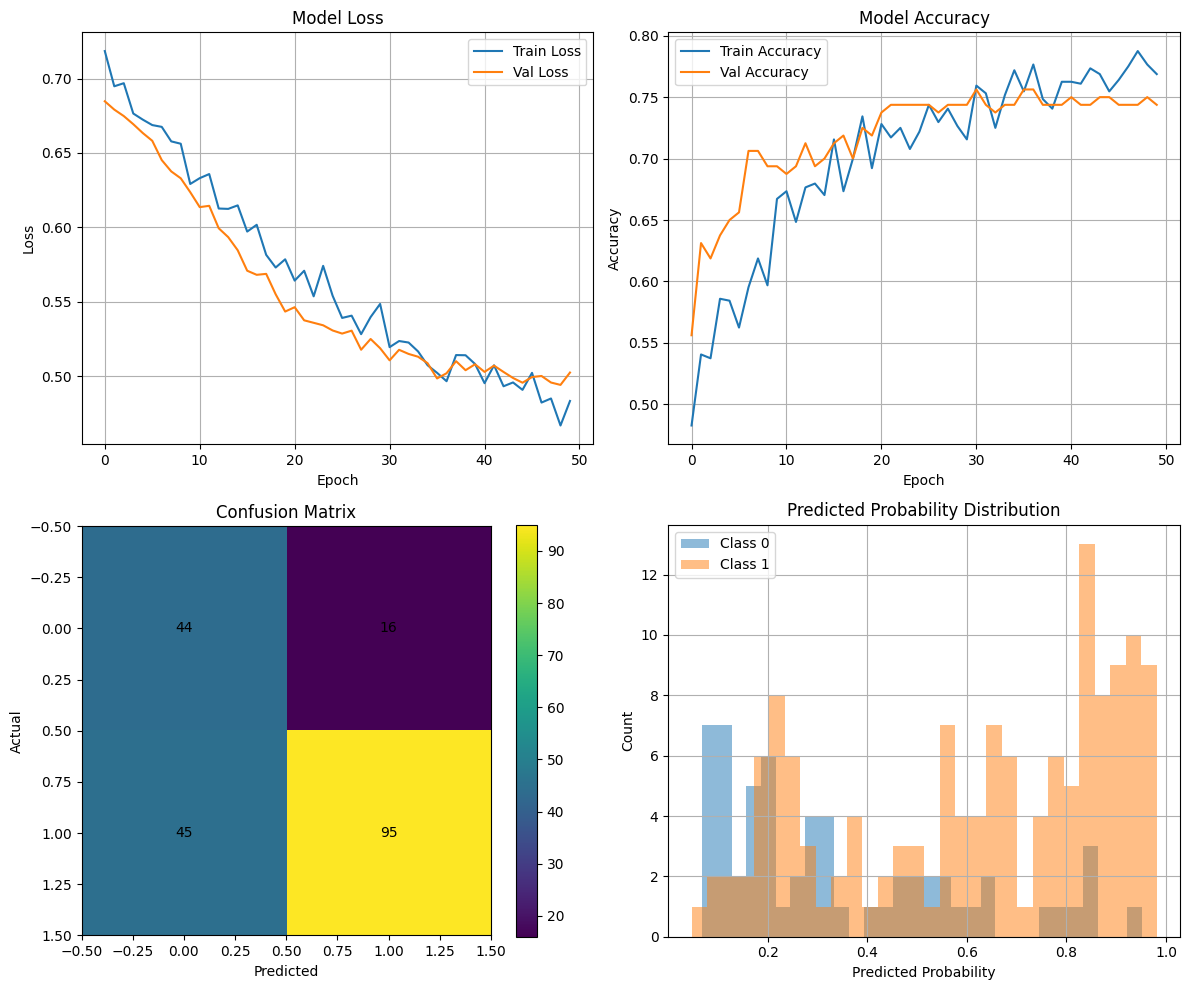

False Positives: 16 | False Negatives: 45


In [133]:
# Evaluate
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

print("\nClassification Report:")

plt.grid()

print(classification_report(y_test, y_pred))

plot_all_in_grid(history, cm, y_test, y_probs)


print(f"False Positives: {cm[0, 1]} | False Negatives: {cm[1, 0]}")

In [134]:
# Save
model.save("./models/credits.model.keras")